In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../cvxportfolio'))


import cvxportfolio as cp


In [14]:
%load_ext autoreload                              
#autoreload reloads modules automatically before entering the execution of code
%autoreload 2                                      
#autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%matplotlib inline                              
#Put the plots inline in the notebook
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


random.seed(0)

plotdir='/home/ahmed/cvxportfolio/'
datadir='../data/' 


start_t=pd.Timestamp(2012,1,1)
end_t=pd.Timestamp(2014,2,20)

print "start_t", type(start_t)
sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]   #index_col=Column to use as the row labels of the DataFrame,
                                                                                #parse_dates=Which columns to combine to parse the date, 
                                                                                #iloc[:,:-1] select all columns without last:


returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
prices=pd.read_csv('/home/ahmeda/cvxportfolio/prices.csv',index_col=0,parse_dates=[0])
covariance=pd.read_csv('/home/ahmeda/cvxportfolio/covariance.csv',index_col=0,parse_dates=[0])
failures=pd.read_csv('/home/ahmeda/cvxportfolio/failures.csv',index_col=0,parse_dates=[0])

sigmas=pd.Series(data=covariance.index=sigmas.index[:len(covariance)])
print sigmas.all

print sigmas.shape, returns.shape,  prices.shape
print prices.all#, type(returns), type(sigmas)
print covariance.all

print len(returns.columns)
initialportfolio=dict(zip(covariance.columns,[random.choice(range(2)) for i in range(len(covariance.columns))]))

w_b = pd.Series(initialportfolio)   
print w_b.all
#A pandas Series is created with all values=1 and an index with all the companies in the trading system of returns.columns=The column labels of the DataFrame.
                                                                            #Company names should be changed to Machine types
w_b.USDOLLAR = 0.
w_b/=sum(w_b)                                                            #Summed the series and divided each element by the sum (so all are  still equal)

start_t=pd.Timestamp(2012,1,1)
end_t=pd.Timestamp(2012,2,1)

simulated_tcost = cp.TcostModelServers(volume=prices)  #Transaction Cost Model class initialization
                                                                                                #This is where the cost of swapping a whole cluster comes and maybe all other costs also?
                                                                         #Equation 2.2 in the paper,  Proportional Spread (a in paper) = Highest close in month (Ask) - Bid (Lowest Close in month) / (Ask + Bid) ÷ 2                  
                                                                    #vOLUME IS THE TOTAL MARKET VOLUME. sigma is the price volatility or std deviation, and the nonline coeff is the constant b in the equation
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)   #Again to be changed with my other costs. A model for holding costs.
print type(simulated_hcost), type(simulated_tcost)

simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=prices, cash_key='USDOLLAR')    #This is the initialization of the simulator platform

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')    #Risk table with the following keys ['/exposures', '/factor_sigma', '/idyos']
print risk_data.info()                              #Exposures: Market exposure refers to the dollar amount of funds, or percentage of a portfolio, invested in a particular type of security, market sector or industry, which is usually expressed as a percentage of total portfolio holdings.
                                                    # Factor: Factor investing is a strategy that chooses securities on attributes that are associated with higher returns
#covMatrix=pd.DataFrame.to_panel(covariance)
risk_model = cp.RobustSigma(Sigma=covariance, epsilon=1)
print type(risk_model), type(risk_data)

#print risk_data. select('exposures')
#Should be changed with either RobustSigma (Used in Exosphere I believe) or WorstCaseRisk http://cvxportfolio.org/documentation/risks/index.html

results={}   #The results dictionary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
start_t <class 'pandas._libs.tslibs.timestamps.Timestamp'>
<bound method Series.all of Date
2007-01-03          (c, 4, ., 2, x, l, a, r, g, e)
2007-01-04          (c, 4, ., 4, x, l, a, r, g, e)
2007-01-05          (c, 4, ., 8, x, l, a, r, g, e)
2007-01-08                (c, 4, ., l, a, r, g, e)
2007-01-09             (c, 4, ., x, l, a, r, g, e)
2007-01-10       (c, 5, ., 1, 8, x, l, a, r, g, e)
2007-01-11          (c, 5, ., 2, x, l, a, r, g, e)
2007-01-12          (c, 5, ., 4, x, l, a, r, g, e)
2007-01-16          (c, 5, ., 9, x, l, a, r, g, e)
2007-01-17                (c, 5, ., l, a, r, g, e)
2007-01-18             (c, 5, ., x, l, a, r, g, e)
2007-01-19    (c, 5, d, ., 1, 8, x, l, a, r, g, e)
2007-01-22       (c, 5, d, ., 2, x, l, a, r, g, e)
2007-01-23       (c, 5, d, ., 4, x, l, a, r, g, e)
2007-01-24       (c, 5, d, ., 9, x, l, a, r, g, e)
2007-01-25             (c, 5, d, ., l, a, r, g, e)
2007

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/risk_model.h5
/exposures               wide         (shape->[60,15,432])
/factor_sigma            wide         (shape->[60,15,15]) 
/idyos                   frame        (shape->[60,432])   
<class 'cvxportfolio.risks.RobustSigma'> <class 'pandas.io.pytables.HDFStore'>


In [7]:
all_return_estimates={}
#n_p1=returns.shape
#print returns.all   #I can not be using these returns as they screw up my life. 
#T=returns.shape

zeroreturns=dict(zip(returns.columns,[random.choice(range(1)) for i in range(len(returns.columns))]))

returns=pd.Series(zeroreturns) 
print T
tempfile=open("ahmed.out",'w')

# for i,t in enumerate(returns.index[:-1]):
#     all_return_estimates[(t,t)]= return_estimate.loc[t]
#     tp1=returns.index[i+1]
#     all_return_estimates[(t,tp1)]=return_estimate.loc[tp1]

all_return_estimates=returns

print>>tempfile,  all_return_estimates.items()
    
    
returns_forecast = cp.MPOReturnsForecast(all_return_estimates)
print dir(returns_forecast)
results_MPO={}

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__metaclass__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', 'alpha_data', 'value_expr', 'weight_expr', 'weight_expr_ahead']


## MPO Coarse search 

In [8]:
import cvxpy as cvx
policies={}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1,2,5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=False))})

TypeError: Cannot compare type 'Timestamp' with type 'str'

In [5]:
result_df_coarse=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

IOError: [Errno 2] No such file or directory: '/home/ahmed/cvxportfolio/mpo_riskrewardfrontier.png'

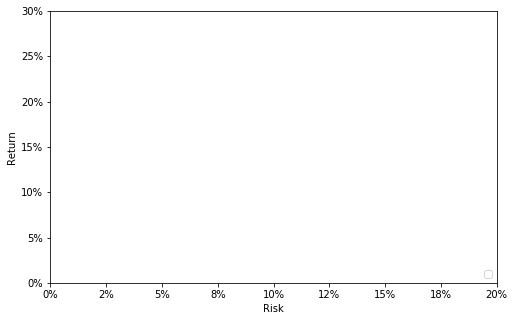

In [6]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_riskrewardfrontier.png')

# MPO Pareto search 

In [17]:
results_pareto={}

In [ ]:
policies={}
#gamma_risks_pareto=[int(round(el)) for el in np.logspace(0,3,13)]
gamma_risks_pareto=[1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[7,8,9,10,11,12]
gamma_holdings=[.1,1.,10., 100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
      cp.MultiPeriodOpt(alpha_model=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, 
                                 gamma_holding*optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,
                                                                                end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [55]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'mpo_pareto_results.csv', float_format='%g')

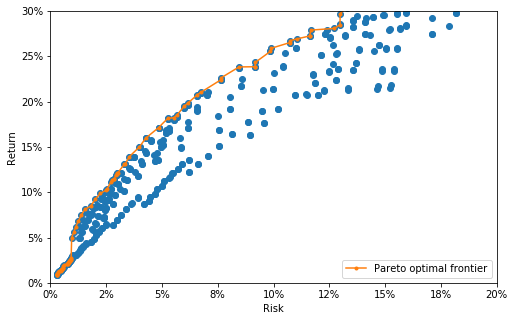

In [56]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_pareto.png')

In [21]:
xlim=20
ylim=30
tableprint=table[table.is_pareto]
tableprint=tableprint[tableprint.Risk <= xlim]
tableprint=tableprint[tableprint.Return <= ylim]
del tableprint['is_pareto']
tableprint.Risk=tableprint.Risk.apply(lambda x: '%.2f%%'%x)
tableprint.Return=tableprint.Return.apply(lambda x: '%.2f%%'%x)
print(tableprint.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                 1000.0 &                       12 &                   1000 &   0.83\% &   0.29\% \\
                 1000.0 &                       12 &                    100 &   0.86\% &   0.29\% \\
                 1000.0 &                       11 &                   1000 &   0.88\% &   0.30\% \\
                 1000.0 &                       11 &                    100 &   0.92\% &   0.31\% \\
                 1000.0 &                       10 &                   1000 &   0.93\% &   0.32\% \\
                 1000.0 &                       10 &                    100 &   1.00\% &   0.32\% \\
                 1000.0 &                        9 &                    100 &   1.08\% &   0.34\% \\
                 1000.0 &                        8 &                    100 &   1.19\% &   0.35\% \\
                 1000.0 &                        7 &

# SPO vs MPO 

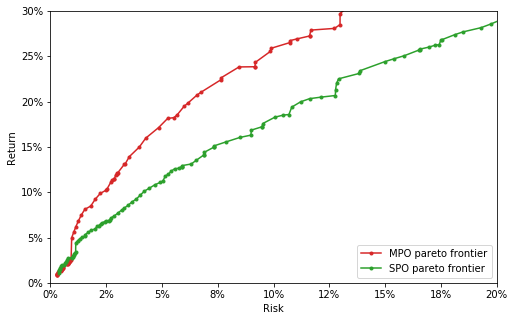

In [57]:
table_spo = pd.read_csv('spo_pareto_results.csv', index_col=0)
plt.figure(figsize=(8,5))

plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')
plt.plot(table_spo[table_spo.is_pareto].Risk,
         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))


plt.savefig(plotdir+'spo_vs_mpo_pareto.png')